In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import psycopg
import spacy
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from transformers import XLMRobertaModel, XLMRobertaTokenizer
from pgvector.psycopg import register_vector
from sklearn.manifold import TSNE
from spacy.tokens import Doc

In [2]:
conn = psycopg.connect(
    dbname="postgres_db",
    user="postgres_user",
    password="postgres_password",
    host="veld_embeddings_platform_run_server",
    port="5432"
)
conn.autocommit = True
register_vector(conn)
cursor = conn.cursor()
cursor.execute("SELECT version();")
print(cursor.fetchone())

('PostgreSQL 17.4 on x86_64-pc-linux-gnu, compiled by gcc (Debian 10.2.1-6) 10.2.1 20210110, 64-bit',)


In [3]:
#MODEL_NAME = "deepset/gbert-base"
MODEL_NAME = "dbmdz/bert-base-german-cased"
#MODEL_NAME = "FacebookAI/xlm-roberta-large"
#MODEL_NAME = "FacebookAI/roberta-large"
TABLE = "embeddings__dbmdz__bert_base_german_cased__test"
IS_TEST = False

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
#tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)
#model = XLMRobertaModel.from_pretrained(MODEL_NAME)
model.eval()
nlp = spacy.load("de_core_news_sm")

In [5]:
@dataclass
class TextEmbedded:
    text: str
    token_list: list
    embedding_list: list
    lemma_list: list

In [6]:
def create_text_embedded(text, tokens_list, embeddings_list):
    
    token_embedding_pair_list = []
    token_list = []
    embedding_list = []
    lemma_list = []
    t_prev = None
    e_prev = []
    for i, (t, e) in enumerate(zip(tokens_list, embeddings_list)):
        if t and t.startswith("##"):
            t_prev += t[2:]
            e_prev.append(e)
        else:
            if t_prev:
                token_list.append(t_prev)
                embedding_list.append(torch.mean(torch.stack(e_prev), dim=0))
            t_prev = t
            e_prev = [e]
    token_list.append(t_prev)
    embedding_list.append(torch.mean(torch.stack(e_prev), dim=0))

    doc = Doc(nlp.vocab, words=token_list)
    doc = nlp.get_pipe("tok2vec")(doc)
    doc = nlp.get_pipe("lemmatizer")(doc)
    for token in doc:
        lemma_list.append(token.lemma_)
    
    return TextEmbedded(text=text, token_list=token_list, embedding_list=embedding_list, lemma_list=lemma_list)

In [7]:
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.squeeze(0)
    return create_text_embedded(text, tokens, embeddings)

In [8]:
def insert_into_db(table, text_embedded):
    cursor.execute(
        f"insert into sentences (text) values (%s) returning sentence_id",
        ((text_embedded.text, ))
    )
    sentence_id = cursor.fetchone()[0]
    for token_index, (token, lemma, embedding) in enumerate(zip(text_embedded.token_list, text_embedded.lemma_list, text_embedded.embedding_list)):
        cursor.execute(
            "insert into lemma (lemma) values (%s) on conflict (lemma) do nothing",
            ((lemma,))
        )
        cursor.execute(
            f"insert into {table} (sentence_id, token_index, word, lemma, embedding) values (%s, %s, %s, %s, %s)",
            (sentence_id, token_index, token, lemma, embedding.tolist())
        )

In [9]:
def iterate_over_file():
    with open("/veld/input/data.txt", "r") as f:
        for l in f:
            yield l

In [ ]:
limit = 20
for i, text in enumerate(iterate_over_file()):
    if IS_TEST and i == limit - 1:
        break
    text_embedded = get_embeddings(text)
    #print(text_embedded.lemma_list)
    #print(text_embedded.token_list)
    #print(text)
    insert_into_db(TABLE, text_embedded)

In [5]:
def show_plot_tsne(rows, title=None):

    # get labels and values
    #labels = []
    #values = []
    #for w in WORD_LIST:
    #    labels.append(w)
    #    values.append(vector_dict[w])
    labels = [r[0] for r in rows]
    values = [r[1] for r in rows]
    values = np.array(values)

    # reduce
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    reduced_vectors_tsne = tsne.fit_transform(values)
    
    # Plot the reduced vectors
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_vectors_tsne[:, 0], reduced_vectors_tsne[:, 1], c='blue', alpha=0.7)

    # Add labels
    for i, label in enumerate(labels):
        plt.text(
            reduced_vectors_tsne[i, 0], 
            reduced_vectors_tsne[i, 1], 
            label,
            fontsize=9, 
            ha="right", 
            color="black"
        )
        
    # plot
    #plt.title(title)
    plt.show()

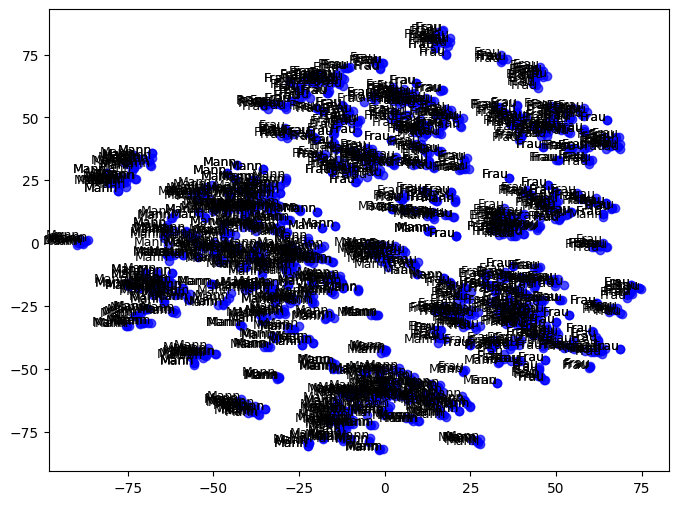

In [11]:
cursor.execute(
    "select lemma, embedding "
    "from embeddings__dbmdz__bert_base_german_cased__test "
    "where lemma='Frau';"
)
rows_frau = cursor.fetchall()

cursor.execute(
    "select lemma, embedding "
    "from embeddings__dbmdz__bert_base_german_cased__test "
    "where lemma='Mann';"
)
rows_mann = cursor.fetchall()

rows_together = rows_frau + rows_mann
show_plot_tsne(rows_together)

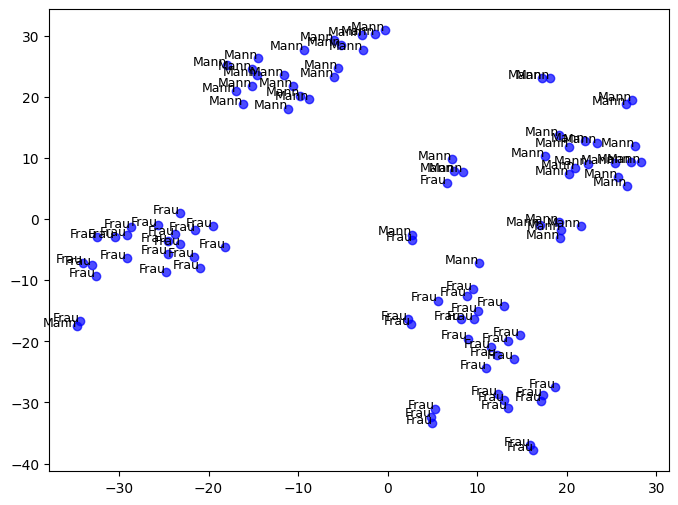

In [32]:
def merge_col_to_label(rows):
    rows_new = []
    for r in rows:
        if False:
            rows_new.append((r[0] + "-" + str(r[1]) + "-" + str(r[2]), r[3]))
        else:
            rows_new.append((r[0], r[3]))
    return rows_new

cursor.execute(
    "select lemma, sentence_id, token_index, embedding "
    "from embeddings__dbmdz__bert_base_german_cased__test "
    "where lemma='Frau'order by sentence_id limit 50;"
)
rows_frau = cursor.fetchall()

cursor.execute(
    "select lemma, sentence_id, token_index, embedding "
    "from embeddings__dbmdz__bert_base_german_cased__test "
    "where lemma='Mann' order by sentence_id limit 50;"
)
rows_mann = cursor.fetchall()

rows_together = rows_frau + rows_mann
rows_together = merge_col_to_label(rows_together)
show_plot_tsne(rows_together)

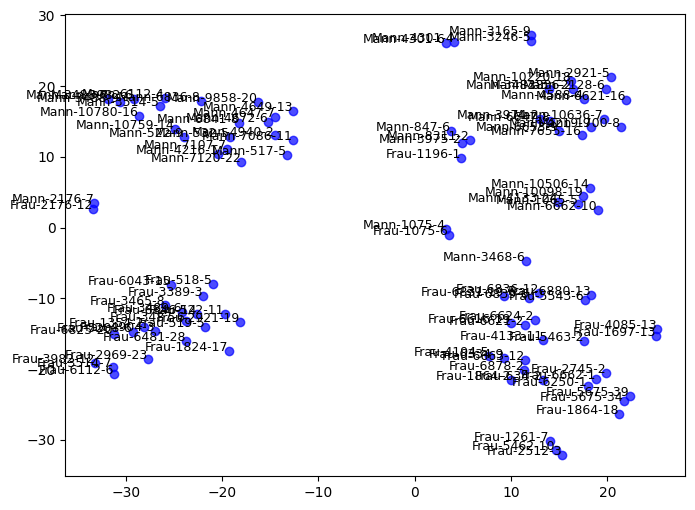

In [33]:
def merge_col_to_label(rows):
    rows_new = []
    for r in rows:
        if True:
            rows_new.append((r[0] + "-" + str(r[1]) + "-" + str(r[2]), r[3]))
        else:
            rows_new.append((r[0], r[3]))
    return rows_new

cursor.execute(
    "select lemma, sentence_id, token_index, embedding "
    "from embeddings__dbmdz__bert_base_german_cased__test "
    "where lemma='Frau'order by sentence_id limit 50;"
)
rows_frau = cursor.fetchall()

cursor.execute(
    "select lemma, sentence_id, token_index, embedding "
    "from embeddings__dbmdz__bert_base_german_cased__test "
    "where lemma='Mann' order by sentence_id limit 50;"
)
rows_mann = cursor.fetchall()

rows_together = rows_frau + rows_mann
rows_together = merge_col_to_label(rows_together)
show_plot_tsne(rows_together)